In [511]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [512]:
# Load the dataset
data = pd.read_csv('train.csv')
# Check the first few rows of the dataset
data.head()

,tarih,ilce,bildirimsiz_sum,bildirimli_sum
0,2021-01-01,izmir-aliaga,5,0
1,2021-01-02,izmir-aliaga,13,0
2,2021-01-03,izmir-aliaga,4,0
3,2021-01-04,izmir-aliaga,9,0
4,2021-01-05,izmir-aliaga,2,0


In [513]:
# Load the dataset
test_df = pd.read_csv('test.csv')
# Check the first few rows of the dataset
test_df.head()

,tarih,ilce,bildirimli_sum
0,2024-02-01,izmir-aliaga,0
1,2024-02-01,izmir-bayindir,1
2,2024-02-01,izmir-bayrakli,0
3,2024-02-01,izmir-bergama,1
4,2024-02-01,izmir-bornova,1


In [514]:
# Descriptive statistics
print(data.describe().T)

                   count      mean       std  min  25%  50%  75%   max
bildirimsiz_sum  48148.0  5.886911  5.425645  0.0  2.0  4.0  8.0  93.0
bildirimli_sum   48148.0  0.798849  1.315394  0.0  0.0  0.0  1.0  19.0


In [515]:
# Provide information about DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48148 entries, 0 to 48147
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tarih            48148 non-null  object
 1   ilce             48148 non-null  object
 2   bildirimsiz_sum  48148 non-null  int64 
 3   bildirimli_sum   48148 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.5+ MB


In [516]:
# Changing the column names from "date" to "date" in the "data" variable
data = data.rename(columns={'tarih':'date'})

# Convert 'Tarih' column to datetime format and set it as index
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

In [517]:
# Changing the column names from "date" to "date" in the "data" variable
test_df = test_df.rename(columns={'tarih':'date'})

# Convert 'Tarih' column to datetime format and set it as index
test_df['date'] = pd.to_datetime(test_df['date'])
test_df = test_df.set_index('date')

In [518]:
# Determining season based on a date object (datetime.datetime)
def get_season(date_obj):
    """
    Determine the season for the given date.
    
    Parameters:
    - date_obj (datetime.datetime): The date to determine the season for.

    Returns:
    - str: The name of the season.
    """
    month = date_obj.month

    if 3 <= month <= 5:
        return 1 #"Spring"
    elif 6 <= month <= 8:
        return 2 #"Summer"
    elif 9 <= month <= 11:
        return 3#"Autumn"
    else:
        return 0#"Winter"

In [519]:
data.head()

,ilce,bildirimsiz_sum,bildirimli_sum
date,,,
2021-01-01,izmir-aliaga,5,0
2021-01-02,izmir-aliaga,13,0
2021-01-03,izmir-aliaga,4,0
2021-01-04,izmir-aliaga,9,0
2021-01-05,izmir-aliaga,2,0


In [520]:
# Convert initials of text values in DataFrame's "district" column to uppercase
data.ilce = data.ilce.str.title()

In [521]:
# Convert initials of text values in DataFrame's "district" column to uppercase
test_df.ilce = test_df.ilce.str.title()

In [522]:
#  DataFrame'in zaman serisi dizinine dayalı özellikler oluştur
def create_features(data):
  """
create time series features based on time series index.
  """
  #data = data.copy()
  covid_start = pd.to_datetime('01-03-2020')
  covid_end = pd.to_datetime('07-01-2021')
  data['dayofweek'] = data.index.day_of_week
  data['quarter'] = data.index.quarter
  data['month'] = data.index.month
  data['year'] = data.index.year
  data['dayofyear'] = data.index.dayofyear
  data['weekend_flag'] = [1 if el > 4 else 0 for el in data['dayofweek']]
  data['date'] = data.index
  data['season'] = data.date.apply(get_season)
  covid_start = pd.to_datetime('03-01-2020')
  covid_end = pd.to_datetime('07-01-2021')
  data['covid_flag'] = [1 if el > covid_start and el < covid_end else 0 for el in data.index]
  data.drop('date', axis=1, inplace=True)
  return data
data = create_features(data)
test_df = create_features(test_df)
#documentation reference => The day of the week with Monday=0, Sunday=6.

In [523]:
# Creating new "province" and "district_" columns by separating the values in the "district" column according to the '-' character
data['il'] = [el.split('-')[0] for el in data['ilce']]
data['ilce_'] = [el.split('-')[1] for el in data['ilce']]

In [524]:
data.head()

,ilce,bildirimsiz_sum,bildirimli_sum,dayofweek,quarter,month,year,dayofyear,weekend_flag,season,covid_flag,il,ilce_
date,,,,,,,,,,,,,
2021-01-01,Izmir-Aliaga,5,0,4,1,1,2021,1,0,0,1,Izmir,Aliaga
2021-01-02,Izmir-Aliaga,13,0,5,1,1,2021,2,1,0,1,Izmir,Aliaga
2021-01-03,Izmir-Aliaga,4,0,6,1,1,2021,3,1,0,1,Izmir,Aliaga
2021-01-04,Izmir-Aliaga,9,0,0,1,1,2021,4,0,0,1,Izmir,Aliaga
2021-01-05,Izmir-Aliaga,2,0,1,1,1,2021,5,0,0,1,Izmir,Aliaga


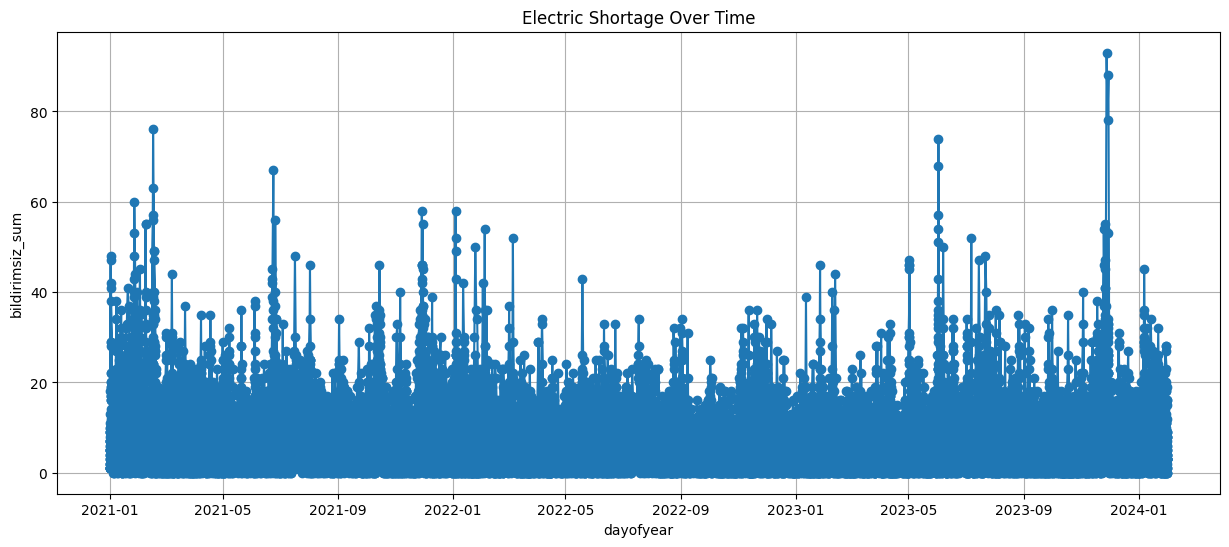

In [525]:
# Draw a line chart using time as the transaction index and showing values in the undeclared_sum column
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['bildirimsiz_sum'], marker='o', linestyle='-', label='Actual')
plt.title('Electric Shortage Over Time')
plt.xlabel('dayofyear')
plt.ylabel('bildirimsiz_sum')
plt.grid(True)

In [526]:
# Load the dataset
weather = pd.read_csv('weather.csv')
weather.head()

,date,lat,lon,t_2m:C,effective_cloud_cover:p,global_rad:W,relative_humidity_2m:p,wind_dir_10m:d,wind_speed_10m:ms,prob_precip_1h:p,t_apparent:C,name
0,2021-01-01 00:00:00,38.6184,28.6712,7.6,10.5,0.0,86.1,173.3,2.6,1.0,5.9,Manisa-Ahmetli
1,2021-01-01 01:00:00,38.6184,28.6712,7.4,6.8,0.0,88.0,174.5,2.7,1.0,5.7,Manisa-Ahmetli
2,2021-01-01 02:00:00,38.6184,28.6712,7.3,4.3,0.0,90.0,177.5,2.8,1.0,5.4,Manisa-Ahmetli
3,2021-01-01 03:00:00,38.6184,28.6712,7.2,8.9,0.0,90.8,175.3,2.7,1.0,5.3,Manisa-Ahmetli
4,2021-01-01 04:00:00,38.6184,28.6712,8.0,22.1,0.0,89.7,172.1,2.5,1.0,6.5,Manisa-Ahmetli


In [527]:
# Renaming the "name" column of the "weather" DataFrame to "county"
weather = weather.rename(columns={'name':'ilce'})

In [528]:
# Counts the number of unique values in the "county" column in the "weather" DataFrame and displays the number of times each unique value occurs
weather['ilce'].value_counts()

ilce
Manisa-Ahmetli       27720
Izmir-Kinik          27720
Izmir-Foca           27720
Izmir-Gaziemir       27720
Izmir-Guzelbahce     27720
Izmir-Karabaglar     27720
Izmir-Karaburun      27720
Izmir-Karsiyaka      27720
Izmir-Kemalpasa      27720
Izmir-Kiraz          27720
Izmir-Konak          27720
Izmir-Menderes       27720
Izmir-Buca           27720
Izmir-Menemen        27720
Izmir-Narlidere      27720
Izmir-Seferihisar    27720
Izmir-Selcuk         27720
Izmir-Tire           27720
Izmir-Torbali        27720
Izmir-Urla           27720
Izmir-Cesme          27720
Izmir-Cigli          27720
Izmir-Dikili         27720
Izmir-Bornova        27720
Manisa-Akhisar       27720
Manisa-Sarigol       27720
Manisa-Alasehir      27720
Manisa-Demirci       27720
Manisa-Golmarmara    27720
Manisa-Gordes        27720
Manisa-Kula          27720
Manisa-Koprubasi     27720
Manisa-Kirkagac      27720
Manisa-Salihli       27720
Manisa-Saruhanli     27720
Manisa-Selendi       27720
Izmir-Beydag         27

In [529]:
weather.columns

Index(['date', 'lat', 'lon', 't_2m:C', 'effective_cloud_cover:p',
       'global_rad:W', 'relative_humidity_2m:p', 'wind_dir_10m:d',
       'wind_speed_10m:ms', 'prob_precip_1h:p', 't_apparent:C', 'ilce'],
      dtype='object')

In [530]:
# Defining a function that controls certain properties of a DataFrame
def check_df(df):
    print(f'weather["ilce"].value_counts() = {weather["ilce"].value_counts()}')
    print(f'weather.columns = {weather.columns}')
    print(f'weather.isnull().sum() = {weather.isnull().sum()}')
    print(f'weather.isna().sum() = {weather.isna().sum()}')
    return
check_df(weather)

weather["ilce"].value_counts() = ilce
Manisa-Ahmetli       27720
Izmir-Kinik          27720
Izmir-Foca           27720
Izmir-Gaziemir       27720
Izmir-Guzelbahce     27720
Izmir-Karabaglar     27720
Izmir-Karaburun      27720
Izmir-Karsiyaka      27720
Izmir-Kemalpasa      27720
Izmir-Kiraz          27720
Izmir-Konak          27720
Izmir-Menderes       27720
Izmir-Buca           27720
Izmir-Menemen        27720
Izmir-Narlidere      27720
Izmir-Seferihisar    27720
Izmir-Selcuk         27720
Izmir-Tire           27720
Izmir-Torbali        27720
Izmir-Urla           27720
Izmir-Cesme          27720
Izmir-Cigli          27720
Izmir-Dikili         27720
Izmir-Bornova        27720
Manisa-Akhisar       27720
Manisa-Sarigol       27720
Manisa-Alasehir      27720
Manisa-Demirci       27720
Manisa-Golmarmara    27720
Manisa-Gordes        27720
Manisa-Kula          27720
Manisa-Koprubasi     27720
Manisa-Kirkagac      27720
Manisa-Salihli       27720
Manisa-Saruhanli     27720
Manisa-Selendi   

In [531]:
#  Defining a function to calculate wind speeds to DataFrame
def create_wind_velocities(df):
    df['wind_sin'] = [np.sin(np.deg2rad(el)) for el in df['wind_dir_10m:d']]
    df['wind_cos'] = [np.cos(np.deg2rad(el)) for el in df['wind_dir_10m:d']]
    df['wind_sin_speed'] = df['wind_sin'] * df['wind_speed_10m:ms']
    df['wind_cos_speed'] = df['wind_cos'] * df['wind_speed_10m:ms']
    df.drop(columns=['wind_sin','wind_cos'], inplace=True)
    return df
weather = create_wind_velocities(weather).copy()

In [532]:

# First, make sure your index is of datetime type
weather.date = pd.to_datetime(weather.date)
weather = weather.set_index('date')

# Step 1: Filter the values of the index for each region until '2024-01-29'
filtered_data = pd.DataFrame()

for region, region_data in weather.groupby('ilce'):
    filtered_region_data = region_data.loc[:'2024-01-29']
    filtered_data = pd.concat([filtered_data, filtered_region_data])

# Step 2: Calculate the mean of numerical values of hourly dates for each region
daily_mean_by_region = filtered_data.groupby([filtered_data.index.date, 'ilce']).mean()

# Step 3: Create a new daily dataframe with the calculated mean values
daily_mean_by_region.reset_index(inplace=True)

# Print the resulting daily dataframe
daily_mean_by_region.head()

,level_0,ilce,lat,lon,t_2m:C,effective_cloud_cover:p,global_rad:W,relative_humidity_2m:p,wind_dir_10m:d,wind_speed_10m:ms,prob_precip_1h:p,t_apparent:C,wind_sin_speed,wind_cos_speed
0,2021-01-01,Izmir-Aliaga,38.7996,26.9707,13.275000,55.045833,73.020833,85.991667,167.204167,4.266667,1.000000,13.929167,0.627170,-4.085336
1,2021-01-01,Izmir-Balcova,38.3891,27.0500,13.087500,60.450000,65.987500,88.166667,145.366667,3.279167,1.287500,13.858333,1.840068,-2.694578
2,2021-01-01,Izmir-Bayindir,38.2178,27.6478,11.333333,66.000000,63.304167,89.245833,58.483333,1.666667,1.000000,12.033333,1.187914,0.947919
3,2021-01-01,Izmir-Bayrakli,38.4612,27.1881,12.741667,58.254167,66.445833,89.212500,141.758333,2.645833,1.216667,13.591667,1.540777,-2.098693
4,2021-01-01,Izmir-Bergama,39.1214,27.1799,11.841667,63.004167,64.458333,87.283333,186.416667,1.695833,1.000000,12.583333,-0.984788,-0.755278


In [533]:
# Step 1: Filter the values of the index for each region between '2024-02-01':'2024-02-29'
filtered_test = pd.DataFrame()

for region, region_data in weather.groupby('ilce'):
    filtered_region_test = region_data.loc['2024-02-01':'2024-02-29']
    filtered_test = pd.concat([filtered_test, filtered_region_test])

# Step 2: Calculate the mean of numerical values of hourly dates for each region
daily_mean_by_region_test = filtered_test.groupby([filtered_test.index.date, 'ilce']).mean()

# Step 3: Create a new daily dataframe with the calculated mean values
daily_mean_by_region_test.reset_index(inplace=True)

# Print the resulting daily dataframe
daily_mean_by_region_test.head()

,level_0,ilce,lat,lon,t_2m:C,effective_cloud_cover:p,global_rad:W,relative_humidity_2m:p,wind_dir_10m:d,wind_speed_10m:ms,prob_precip_1h:p,t_apparent:C,wind_sin_speed,wind_cos_speed
0,2024-02-01,Izmir-Aliaga,38.7996,26.9707,7.616667,10.037500,142.629167,72.116667,34.337500,4.941667,1.0,6.395833,2.781604,3.991273
1,2024-02-01,Izmir-Balcova,38.3891,27.0500,7.462500,4.725000,145.991667,76.816667,299.679167,2.358333,1.0,7.766667,-0.656829,2.207418
2,2024-02-01,Izmir-Bayindir,38.2178,27.6478,6.429167,13.562500,142.212500,77.904167,95.187500,2.212500,1.0,6.262500,0.238225,2.175750
3,2024-02-01,Izmir-Bayrakli,38.4612,27.1881,6.954167,9.041667,144.870833,76.537500,36.870833,2.395833,1.0,6.920833,0.896489,2.152309
4,2024-02-01,Izmir-Bergama,39.1214,27.1799,6.575000,34.620833,133.125000,73.729167,51.166667,3.670833,1.0,5.591667,2.914898,2.188658


In [534]:
# Filter and display the last five observations of daily average values for the "Izmir-Aliaga" district
daily_mean_by_region[daily_mean_by_region['ilce']=='Izmir-Aliaga'].tail()

,level_0,ilce,lat,lon,t_2m:C,effective_cloud_cover:p,global_rad:W,relative_humidity_2m:p,wind_dir_10m:d,wind_speed_10m:ms,prob_precip_1h:p,t_apparent:C,wind_sin_speed,wind_cos_speed
52593,2024-01-25,Izmir-Aliaga,38.7996,26.9707,7.333333,52.945833,112.979167,75.120833,114.633333,1.937500,6.816667,7.120833,1.128808,0.733727
52640,2024-01-26,Izmir-Aliaga,38.7996,26.9707,8.216667,18.879167,117.379167,73.804167,127.241667,2.087500,1.000000,8.345833,1.201490,0.994154
52687,2024-01-27,Izmir-Aliaga,38.7996,26.9707,8.229167,47.841667,106.975000,69.116667,111.366667,2.125000,1.654167,7.970833,1.731634,0.429750
52734,2024-01-28,Izmir-Aliaga,38.7996,26.9707,7.179167,22.533333,130.708333,71.662500,40.804167,5.379167,1.000000,5.766667,3.388981,4.122619
52781,2024-01-29,Izmir-Aliaga,38.7996,26.9707,5.670833,39.979167,112.304167,72.920833,33.433333,7.479167,1.000000,2.412500,4.027898,6.270940


In [535]:
# Rename columns "level_0" to "date" in data frames daily_mean_by_region and daily_mean_by_region_test
daily_mean_by_region = daily_mean_by_region.rename(columns = {'level_0':'date'})
daily_mean_by_region_test = daily_mean_by_region_test.rename(columns = {'level_0':'date'})

In [536]:
# Sorting daily_mean_by_region and daily_mean_by_region_test data frames by "county" and "date" columns
daily_mean_by_region = daily_mean_by_region.sort_values(by=['ilce','date'])
daily_mean_by_region_test = daily_mean_by_region_test.sort_values(by=['ilce','date'])

In [537]:
# First, make sure your index is of datetime type
daily_mean_by_region.date = pd.to_datetime(daily_mean_by_region.date)
daily_mean_by_region = daily_mean_by_region.set_index('date')

daily_mean_by_region_test.date = pd.to_datetime(daily_mean_by_region_test.date)
daily_mean_by_region_test = daily_mean_by_region_test.set_index('date')

In [538]:
daily_mean_by_region_test.head()

,ilce,lat,lon,t_2m:C,effective_cloud_cover:p,global_rad:W,relative_humidity_2m:p,wind_dir_10m:d,wind_speed_10m:ms,prob_precip_1h:p,t_apparent:C,wind_sin_speed,wind_cos_speed
date,,,,,,,,,,,,,
2024-02-01,Izmir-Aliaga,38.7996,26.9707,7.616667,10.037500,142.629167,72.116667,34.337500,4.941667,1.000000,6.395833,2.781604,3.991273
2024-02-02,Izmir-Aliaga,38.7996,26.9707,7.008333,19.475000,142.316667,71.862500,94.220833,3.283333,1.000000,6.508333,1.640665,2.538851
2024-02-03,Izmir-Aliaga,38.7996,26.9707,8.258333,21.616667,139.112500,68.158333,77.529167,3.675000,1.000000,7.837500,1.773947,2.931411
2024-02-04,Izmir-Aliaga,38.7996,26.9707,8.866667,26.200000,140.554167,72.541667,145.762500,1.708333,1.329167,9.379167,1.163727,-0.449314
2024-02-05,Izmir-Aliaga,38.7996,26.9707,12.333333,16.395833,141.929167,76.854167,169.658333,3.108333,1.000000,12.854167,0.223013,-2.848441


In [539]:
daily_mean_by_region.ilce.value_counts()

ilce
Izmir-Aliaga         1124
Manisa-Gordes        1124
Izmir-Selcuk         1124
Izmir-Tire           1124
Izmir-Torbali        1124
Izmir-Urla           1124
Manisa-Ahmetli       1124
Manisa-Akhisar       1124
Manisa-Alasehir      1124
Manisa-Demirci       1124
Manisa-Golmarmara    1124
Manisa-Kirkagac      1124
Izmir-Odemis         1124
Manisa-Koprubasi     1124
Manisa-Kula          1124
Manisa-Salihli       1124
Manisa-Sarigol       1124
Manisa-Saruhanli     1124
Manisa-Sehzadeler    1124
Manisa-Selendi       1124
Manisa-Soma          1124
Manisa-Turgutlu      1124
Izmir-Seferihisar    1124
Izmir-Narlidere      1124
Izmir-Balcova        1124
Izmir-Foca           1124
Izmir-Bayindir       1124
Izmir-Bayrakli       1124
Izmir-Bergama        1124
Izmir-Beydag         1124
Izmir-Bornova        1124
Izmir-Buca           1124
Izmir-Cesme          1124
Izmir-Cigli          1124
Izmir-Dikili         1124
Izmir-Gaziemir       1124
Izmir-Menemen        1124
Izmir-Guzelbahce     1124
Izmir-K

In [540]:
# Filters the rows with the value "Manisa-Golmarmara" in the "district" column and returns a DataFrame containing these rows
data.loc[data.ilce=='Manisa-Golmarmara']

,ilce,bildirimsiz_sum,bildirimli_sum,dayofweek,quarter,month,year,dayofyear,weekend_flag,season,covid_flag,il,ilce_
date,,,,,,,,,,,,,
2021-01-01,Manisa-Golmarmara,1,0,4,1,1,2021,1,0,0,1,Manisa,Golmarmara
2021-01-03,Manisa-Golmarmara,3,0,6,1,1,2021,3,1,0,1,Manisa,Golmarmara
2021-01-06,Manisa-Golmarmara,2,0,2,1,1,2021,6,0,0,1,Manisa,Golmarmara
2021-01-07,Manisa-Golmarmara,2,2,3,1,1,2021,7,0,0,1,Manisa,Golmarmara
2021-01-10,Manisa-Golmarmara,1,0,6,1,1,2021,10,1,0,1,Manisa,Golmarmara
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-20,Manisa-Golmarmara,1,0,5,1,1,2024,20,1,0,0,Manisa,Golmarmara
2024-01-23,Manisa-Golmarmara,1,0,1,1,1,2024,23,0,0,0,Manisa,Golmarmara
2024-01-26,Manisa-Golmarmara,1,0,4,1,1,2024,26,0,0,0,Manisa,Golmarmara


In [541]:
data.ilce.value_counts()

ilce
Manisa-Salihli       1126
Manisa-Akhisar       1126
Izmir-Cesme          1125
Izmir-Menderes       1125
Manisa-Yunusemre     1125
Izmir-Bornova        1124
Izmir-Torbali        1124
Izmir-Odemis         1124
Izmir-Konak          1124
Manisa-Sehzadeler    1123
Izmir-Urla           1122
Manisa-Turgutlu      1121
Izmir-Bergama        1120
Izmir-Dikili         1119
Izmir-Menemen        1119
Manisa-Alasehir      1119
Izmir-Kemalpasa      1118
Izmir-Buca           1115
Izmir-Seferihisar    1111
Izmir-Tire           1107
Izmir-Aliaga         1106
Manisa-Saruhanli     1105
Izmir-Bayindir       1105
Izmir-Karabaglar     1100
Izmir-Kiraz          1097
Izmir-Karaburun      1089
Izmir-Bayrakli       1086
Manisa-Soma          1086
Izmir-Foca           1086
Izmir-Karsiyaka      1085
Izmir-Cigli          1071
Manisa-Gordes        1059
Manisa-Kula          1039
Manisa-Sarigol       1027
Manisa-Selendi        993
Manisa-Kirkagac       950
Manisa-Demirci        938
Izmir-Gaziemir        920
Izmir-K

In [542]:
# Preprocessing of holidays dataset
holidays = pd.read_csv('holidays.csv')
holidays.head()

,Yıl,Ay,Gün,Tatil Adı
0,2021,1,1,New Year's Day
1,2021,4,23,National Sovereignty and Children's Day
2,2021,5,1,Labour Day
3,2021,5,19,"Commemoration of Ataturk, Youth and Sports Day"
4,2021,7,15,Democracy and National Unity Day


In [543]:
# Merge 'year', 'month', and 'day' columns and convert to datetime format
holidays['date'] = pd.to_datetime(holidays[['Yıl', 'Ay', 'Gün']].astype(str).agg('-'.join, axis=1))

# Drop the individual 'year', 'month', and 'day' columns
holidays = holidays.drop(['Yıl', 'Ay', 'Gün'], axis=1)
holidays['holiday']=1
holidays = holidays.drop('Tatil Adı',axis=1)
holidays = holidays.set_index('date')
print(holidays.head())

            holiday
date               
2021-01-01        1
2021-04-23        1
2021-05-01        1
2021-05-19        1
2021-07-15        1


In [544]:
# Merge 'data' and 'holidays' DataFrames on 'date' column
data = data.join(holidays)
test_df = test_df.join(holidays)

# Fill NaN values in 'holiday' column with 0
data['holiday'].fillna(0, inplace = True)
test_df['holiday'].fillna(0, inplace = True)
print("\nMerged DataFrame:")
print(data)
print("\nMerged Test_DataFrame:")
print(test_df)


Merged DataFrame:
                        ilce  bildirimsiz_sum  bildirimli_sum  dayofweek  \
date                                                                       
2021-01-01      Izmir-Aliaga                5               0          4   
2021-01-01    Izmir-Bayindir                3               0          4   
2021-01-01    Izmir-Bayrakli                7               0          4   
2021-01-01     Izmir-Bergama                2               0          4   
2021-01-01     Izmir-Bornova                9               0          4   
...                      ...              ...             ...        ...   
2024-01-31       Manisa-Soma                5               0          2   
2024-01-31   Manisa-Turgutlu                3               0          2   
2024-01-31  Manisa-Yunusemre                8               2          2   
2024-01-31      Izmir-Selcuk                0               2          2   
2024-01-31       Manisa-Kula                4               0        

In [545]:
# By resetting the indexes of DataFrames "data" and "test_df", adding the indexes as a column and thus creating new DataFrames with a reset index
merged_df = data.reset_index()
merged_test = test_df.reset_index()

print(merged_df.head())
print(merged_test.head())

        date            ilce  bildirimsiz_sum  bildirimli_sum  dayofweek  \
0 2021-01-01    Izmir-Aliaga                5               0          4   
1 2021-01-01  Izmir-Bayindir                3               0          4   
2 2021-01-01  Izmir-Bayrakli                7               0          4   
3 2021-01-01   Izmir-Bergama                2               0          4   
4 2021-01-01   Izmir-Bornova                9               0          4   

   quarter  month  year  dayofyear  weekend_flag  season  covid_flag     il  \
0        1      1  2021          1             0       0           1  Izmir   
1        1      1  2021          1             0       0           1  Izmir   
2        1      1  2021          1             0       0           1  Izmir   
3        1      1  2021          1             0       0           1  Izmir   
4        1      1  2021          1             0       0           1  Izmir   

      ilce_  holiday  
0    Aliaga      1.0  
1  Bayindir      1.0  

In [546]:
# Calculate the number of rows belonging to the district "Manisa-Golmarmara"
len(merged_df[merged_df['ilce']=='Manisa-Golmarmara'].index)

566

In [547]:
# Return unique values found in the "district" column of DataFrame "merged_df"
merged_df['ilce'].unique()

array(['Izmir-Aliaga', 'Izmir-Bayindir', 'Izmir-Bayrakli',
       'Izmir-Bergama', 'Izmir-Bornova', 'Izmir-Buca', 'Izmir-Cesme',
       'Izmir-Cigli', 'Izmir-Dikili', 'Izmir-Foca', 'Izmir-Gaziemir',
       'Izmir-Guzelbahce', 'Izmir-Karabaglar', 'Izmir-Karaburun',
       'Izmir-Karsiyaka', 'Izmir-Kemalpasa', 'Izmir-Kinik', 'Izmir-Kiraz',
       'Izmir-Konak', 'Izmir-Menderes', 'Izmir-Menemen', 'Izmir-Odemis',
       'Izmir-Seferihisar', 'Izmir-Tire', 'Izmir-Torbali', 'Izmir-Urla',
       'Manisa-Akhisar', 'Manisa-Alasehir', 'Manisa-Demirci',
       'Manisa-Golmarmara', 'Manisa-Gordes', 'Manisa-Kirkagac',
       'Manisa-Koprubasi', 'Manisa-Salihli', 'Manisa-Sarigol',
       'Manisa-Saruhanli', 'Manisa-Sehzadeler', 'Manisa-Selendi',
       'Manisa-Soma', 'Manisa-Turgutlu', 'Manisa-Yunusemre',
       'Izmir-Balcova', 'Izmir-Beydag', 'Izmir-Narlidere', 'Izmir-Selcuk',
       'Manisa-Kula', 'Manisa-Ahmetli'], dtype=object)

In [548]:
# Returning the index value of the last row belonging to "Manisa-Salihli" district
merged_df.loc[merged_df['ilce'] == 'Manisa-Salihli'].index.max()

48138

In [549]:
# Imports datetime and timedelta classes from the datetime module and then creates a list called "date_list"
from datetime import datetime, timedelta
date_list = [merged_df.date.min() + timedelta(days=x) for x in range((merged_df.date.max() - merged_df.date.min()).days + 1)]
date_list[:5]

[Timestamp('2021-01-01 00:00:00'),
 Timestamp('2021-01-02 00:00:00'),
 Timestamp('2021-01-03 00:00:00'),
 Timestamp('2021-01-04 00:00:00'),
 Timestamp('2021-01-05 00:00:00')]

In [550]:
# Returning the largest date in the date column in DataFrame "merged_df"
merged_df.date.max()

Timestamp('2024-01-31 00:00:00')

In [551]:
def create_empty_dates(df):
    date_min = df.date.min()
    date_max = df.date.max()
    df_cols = df.columns
    df_col_len = len(df.columns)
    new_row_list= []
    date_set = set(date_list)
    for ilce in df.ilce.unique():
        date_pool_for_ilce = df.loc[df['ilce'] == ilce].date
        
        if len(date_pool_for_ilce) != 1126:
            date_diff = date_set - set(list(date_pool_for_ilce))
            
            for date in date_diff:
                
                cols, vals = df_cols, [date, ilce] +(df_col_len-2) * [None]
                new_row = dict(zip(cols, vals))
                new_row_list.append(new_row)
    
        else: print('Das okay')
    df = pd.concat([df, pd.DataFrame(new_row_list)])
    return df

In [552]:
# Importing time module from Python's standard library
import time

In [553]:
# Add missing dates of merged_df DataFrame by calling create empty dates function
start_t = time.time()
merged_df_ = create_empty_dates(merged_df)
finish_t = time.time()
finish_min = (finish_t - start_t) // 60
finish_sec = (finish_t - start_t) % 60
print(f"Finish time: {finish_min} mins, {finish_sec} seconds.")

Das okay
Das okay
Finish time: 0.0 mins, 0.19591236114501953 seconds.


In [554]:
# merged_df_ calculate number of missing values in DataFrame for each column
merged_df_.isna().sum()

date                  0
ilce                  0
bildirimsiz_sum    4774
bildirimli_sum     4774
dayofweek          4774
quarter            4774
month              4774
year               4774
dayofyear          4774
weekend_flag       4774
season             4774
covid_flag         4774
il                 4774
ilce_              4774
holiday            4774
dtype: int64

In [555]:
# merged_df_.date.min() # Timestamp('2021-01-01 00:00:00')
# merged_df_.loc[merged_df_.date == '2021-01-01']
# Define a function to apply ffill to each group
ffill_func = lambda x: x.ffill()
def fill_df_by_ilce(df):
    new_df = pd.DataFrame()
    for ilce in df.ilce.unique():
        part_df = df.loc[df.ilce == ilce].sort_values(by='date')
        new_df1 = part_df.transform(ffill_func)
        new_df = pd.concat([new_df, new_df1])
    
    return new_df

# Define a function to apply ffill to each group
bfill_func = lambda x: x.bfill()
def bfill_df_by_ilce(df):
    new_df = pd.DataFrame()
    for ilce in df.ilce.unique():
        part_df = df.loc[df.ilce == ilce].sort_values(by='date')
        new_df1 = part_df.transform(bfill_func)
        new_df = pd.concat([new_df, new_df1])
    
    return new_df

In [569]:
# Calling the fill_df_by_county function, which fills in the missing dates for the merged_df_ DataFrame for each county
merged_df__ = fill_df_by_ilce(merged_df_)

# Calling the 'bfill_df_by_ilce' function, which fills in missing values by backfilling the DataFrame
merged_df___ = bfill_df_by_ilce(merged_df__)

In [557]:
# merged_df_.loc[merged_df_.ilce == "Izmir-Balcova"].sort_values(by="date")
# merged_df__.loc[merged_df__.ilce == "Izmir-Balcova"].sort_values(by="date")
# merged_df___.loc[merged_df___.ilce == "Izmir-Balcova"].sort_values(by="date")
merged_df___.isna().sum()

date               0
ilce               0
bildirimsiz_sum    0
bildirimli_sum     0
dayofweek          0
quarter            0
month              0
year               0
dayofyear          0
weekend_flag       0
season             0
covid_flag         0
il                 0
ilce_              0
holiday            0
dtype: int64

In [558]:
# Copying the merged_df___ DataFrame to a new DataFrame named merged_df and then deleting the merged_df___ DataFrame from memory
merged_df = merged_df___.copy()
del merged_df___
merged_df.value_counts('ilce')

ilce
Izmir-Aliaga         1126
Manisa-Gordes        1126
Izmir-Selcuk         1126
Izmir-Tire           1126
Izmir-Torbali        1126
Izmir-Urla           1126
Manisa-Ahmetli       1126
Manisa-Akhisar       1126
Manisa-Alasehir      1126
Manisa-Demirci       1126
Manisa-Golmarmara    1126
Manisa-Kirkagac      1126
Izmir-Odemis         1126
Manisa-Koprubasi     1126
Manisa-Kula          1126
Manisa-Salihli       1126
Manisa-Sarigol       1126
Manisa-Saruhanli     1126
Manisa-Sehzadeler    1126
Manisa-Selendi       1126
Manisa-Soma          1126
Manisa-Turgutlu      1126
Izmir-Seferihisar    1126
Izmir-Narlidere      1126
Izmir-Balcova        1126
Izmir-Foca           1126
Izmir-Bayindir       1126
Izmir-Bayrakli       1126
Izmir-Bergama        1126
Izmir-Beydag         1126
Izmir-Bornova        1126
Izmir-Buca           1126
Izmir-Cesme          1126
Izmir-Cigli          1126
Izmir-Dikili         1126
Izmir-Gaziemir       1126
Izmir-Menemen        1126
Izmir-Guzelbahce     1126
Izmir-K

In [559]:
# Merge the two dataframes by the 'ilce' column
merged_df = pd.merge(data, daily_mean_by_region, on=['ilce','date'])
print(merged_df.head())

merged_test = pd.merge(test_df, daily_mean_by_region_test, on=['ilce','date'])
print(merged_test.head())

                      ilce  bildirimsiz_sum  bildirimli_sum  dayofweek  \
date                                                                     
2021-01-01    Izmir-Aliaga                5               0          4   
2021-01-01  Izmir-Bayindir                3               0          4   
2021-01-01  Izmir-Bayrakli                7               0          4   
2021-01-01   Izmir-Bergama                2               0          4   
2021-01-01   Izmir-Bornova                9               0          4   

            quarter  month  year  dayofyear  weekend_flag  season  ...  \
date                                                               ...   
2021-01-01        1      1  2021          1             0       0  ...   
2021-01-01        1      1  2021          1             0       0  ...   
2021-01-01        1      1  2021          1             0       0  ...   
2021-01-01        1      1  2021          1             0       0  ...   
2021-01-01        1      1  2021     

In [560]:
merged_df.columns

Index(['ilce', 'bildirimsiz_sum', 'bildirimli_sum', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear', 'weekend_flag', 'season', 'covid_flag',
       'il', 'ilce_', 'holiday', 'lat', 'lon', 't_2m:C',
       'effective_cloud_cover:p', 'global_rad:W', 'relative_humidity_2m:p',
       'wind_dir_10m:d', 'wind_speed_10m:ms', 'prob_precip_1h:p',
       't_apparent:C', 'wind_sin_speed', 'wind_cos_speed'],
      dtype='object')

Results of Dickey-Fuller Test:
ADF Statistic: -20.000732174315434
p-value: 0.0
Critical Values:
	1%: -3.430485987712377
	5%: -2.8616001037234473
	10%: -2.5668019912333397


<Figure size 1500x600 with 0 Axes>

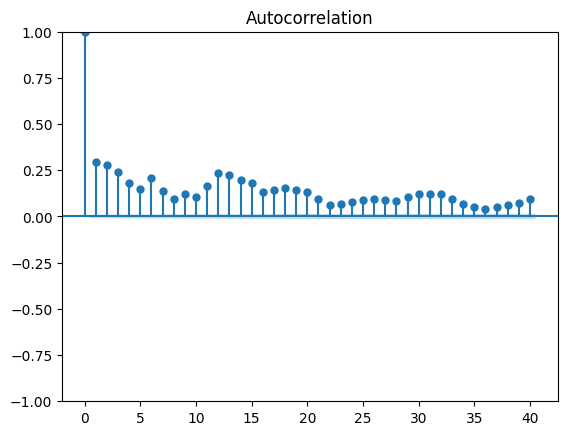

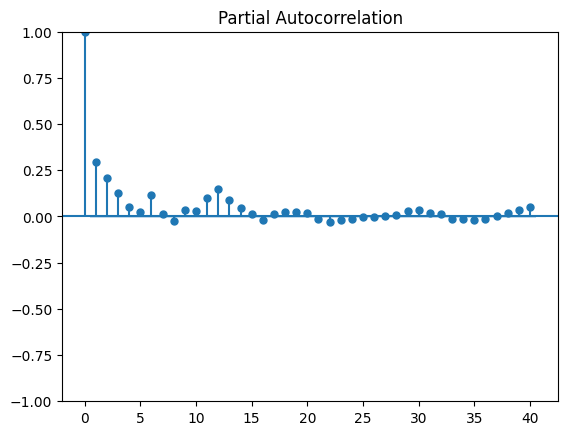

In [561]:
# Function to perform Dickey-Fuller test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

# Perform Dickey-Fuller test
print("Results of Dickey-Fuller Test:")
adf_test(data['bildirimsiz_sum'])

# Plot ACF and PACF
plt.figure(figsize=(15, 6))
plot_acf(data['bildirimsiz_sum'], lags=40)
plot_pacf(data['bildirimsiz_sum'], lags=40)
plt.show()

In [562]:
# Train-test split
train_size = int(len(merged_df) * 0.85)
train, test = merged_df.iloc[:train_size], merged_df.iloc[train_size:]

In [563]:
def grab_col_names(df, cat_th=13, car_th=50):

    # cat_cols, cat_but_car
    cat_cols = [col for col in df.columns if str(df[col].dtypes) in ["category", "object", "bool"]]

    num_but_cat = [col for col in df.columns if df[col].nunique() < cat_th and df[col].dtypes in ["int", "float"]]

    cat_but_car = [col for col in df.columns if
                   df[col].nunique() > car_th and str(df[col].dtypes) in ["category", "object"]]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in df.columns if df[col].dtypes in ["int", "float"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Observations: {df.shape[0]}")
    print(f"Variables: {df.shape[1]}")
    print(f'cat_cols: {cat_cols}')
    print(f'num_cols: {num_cols}')
    print(f'cat_but_car: {cat_but_car}')
    print(f'num_but_cat: {num_but_cat}')

    return cat_cols, num_cols, cat_but_car

In [564]:
cat_cols, num_cols, cat_but_car = grab_col_names(merged_df)

Observations: 48068
Variables: 26
cat_cols: ['ilce', 'il', 'ilce_', 'dayofweek', 'quarter', 'month', 'year', 'holiday']
num_cols: ['dayofyear', 'lat', 'lon', 't_2m:C', 'effective_cloud_cover:p', 'global_rad:W', 'relative_humidity_2m:p', 'wind_dir_10m:d', 'wind_speed_10m:ms', 'prob_precip_1h:p', 't_apparent:C', 'wind_sin_speed', 'wind_cos_speed']
cat_but_car: []
num_but_cat: ['dayofweek', 'quarter', 'month', 'year', 'holiday']


In [565]:
# Machine Learning Models
features = ['bildirimli_sum', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear', 'weekend_flag', 'season', 'covid_flag',
        'holiday', 'lat', 'lon', 't_2m:C',
       'effective_cloud_cover:p', 'global_rad:W', 'relative_humidity_2m:p',
       'wind_dir_10m:d', 'wind_speed_10m:ms', 'prob_precip_1h:p',
       't_apparent:C', 'wind_sin_speed', 'wind_cos_speed']

# # Linear Regression
# lr_model = LinearRegression()
# lr_model.fit(train[features], train['bildirimsiz_sum'])
# lr_forecast = np.round(lr_model.predict(test[features]))
# mae_lr = mean_absolute_error(test['bildirimsiz_sum'], lr_forecast)
# print(f'LR MAE: {mae_lr}')

# # Random Forest
# rf_model = RandomForestRegressor()
# rf_model.fit(train[features], train['bildirimsiz_sum'])
# rf_forecast = np.round(rf_model.predict(test[features]))
# mae_rf = mean_absolute_error(test['bildirimsiz_sum'], rf_forecast)
# print(f'RF MAE: {mae_rf}')

# # SVR
# scaler = StandardScaler()
# scaled_train = scaler.fit_transform(train[features])
# scaled_test = scaler.transform(test[features])

# svr_model = SVR()
# svr_model.fit(scaled_train, train['bildirimsiz_sum'])
# svr_forecast = np.round(svr_model.predict(scaled_test))
# mae_svr = mean_absolute_error(test['bildirimsiz_sum'], svr_forecast)
# print(f'SVR MAE: {mae_svr}')

# # MLPRegressor
# mlp_model = MLPRegressor(random_state=1, max_iter=500)
# mlp_model.fit(train[features], train['bildirimsiz_sum'])
# mlp_forecast = np.round(mlp_model.predict(test[features]))
# mae_mlp = mean_absolute_error(test['bildirimsiz_sum'], mlp_forecast)
# print(f'MLP MAE: {mae_mlp}')

# XGBoost
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 100)
xgb_model.fit(train[features], train['bildirimsiz_sum'])
xgb_forecast = np.round(xgb_model.predict(test[features]))
mae_xgb = mean_absolute_error(test['bildirimsiz_sum'], xgb_forecast)
print(f'XGB MAE: {mae_xgb}')

XGB MAE: 3.1436693939814173


In [566]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,unique_id,bildirimsiz_sum
0,2024-02-01-izmir-aliaga,NaN
1,2024-02-01-izmir-bayindir,NaN
2,2024-02-01-izmir-bayrakli,NaN
3,2024-02-01-izmir-bergama,NaN
4,2024-02-01-izmir-bornova,NaN
...,...,...
1358,2024-02-29-izmir-beydag,NaN
1359,2024-02-29-izmir-narlidere,NaN
1360,2024-02-29-izmir-selcuk,NaN
1361,2024-02-29-manisa-kula,NaN


In [567]:
# Filling missing values (NaN) with zero
sample_submission['bildirimsiz_sum'].fillna(0, inplace=True)

In [568]:
# Saving the submission file we created in CSV format
# sample_submission.to_csv("submission.csv", index=False)